In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
from tqdm.notebook import tqdm as tqdm_notebook
from statsmodels.stats.proportion import proportion_confint
from scipy.stats import norm

/Users/roma/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [52]:
def ttest(sample_a, sample_b, z_sig):
    
    mean_sample_a = np.mean(sample_a)
    mean_sample_b = np.mean(sample_b)
    diff_mean = mean_sample_b - mean_sample_a
    
    std_error_a = np.var(sample_a)/len(sample_a)
    std_error_b = np.var(sample_b)/len(sample_b)
    diff_mean_std_error = std_error_a + std_error_b
    t_stat = diff_mean/np.sqrt(diff_mean_std_error)
    
    if t_stat >= z_sig:
        res = 1
    else:
        res = 0
    return res

In [60]:
def proportion_ztest(sample_a, sample_b, z_sig):
    
    p_a = np.mean(sample_a)
    p_b = np.mean(sample_b)
    diff_mean = p_b - p_a
    
    len_sample_a = len(sample_a)
    len_sample_b = len(sample_b)
    overall_p = (np.sum(sample_a) + np.sum(sample_b))/(len_sample_a + len_sample_b)
    
    diff_mean_std_error = overall_p*(1-overall_p)*((1/len_sample_a) + (1/len_sample_b))
    z_stat = diff_mean/np.sqrt(diff_mean_std_error)
    
    if z_stat >= z_sig:
        res = 1
    else:
        res = 0
    return res

In [64]:
# Зададим исходные параметры
sig = 0.025 # уровень значимости
scale = 1900 # параметр экспоненциального распределения
mean_a = scale # мат.ожидание генеральной совокупности А
mean_b = scale*1.01 # мат.ожидание генеральной совокупности B
z_sig = sps.norm.ppf(1-sig) # 97.5 процентиль стандартного нормального распределения
N = 1000
buckets_num = 200

power_bucket = []
power_ttest = []
sample_size = []

avg_std_ttest = []
avg_std_bucket = []

for n in tqdm_notebook(range(50000, 300000, 25000)):
    
    results_ttest = []
    results_bucket = []
    std_ttest = []
    std_bucket = []
    
    for i in tqdm_notebook(range(N)):

        sample_a = sps.expon(loc=0, scale=mean_a).rvs(n)
        sample_b = sps.expon(loc=0, scale=mean_b).rvs(n)
        res_ttest = ttest(sample_a, sample_b, z_sig)
        results_ttest.append(res_ttest)  
        std_ttest.append((np.var(sample_a) + np.var(sample_b))/n)
        
        bucketized_sample_a = []
        bucketized_sample_b = []
        for b in range(buckets_num):
            bucket_a = sample_a[:buckets_num]
            bucketized_sample_a.append(np.mean(bucket_a))
            sample_a = sample_a[buckets_num:]
            
            bucket_b = sample_b[:buckets_num]
            bucketized_sample_b.append(np.mean(bucket_b))
            sample_b = sample_b[buckets_num:]
        res_bucket = ttest(bucketized_sample_a, bucketized_sample_b, z_sig)
        results_bucket.append(res_bucket)
        std_bucket.append((np.var(bucketized_sample_a) + np.var(bucketized_sample_b))/buckets_num)
           
    power_ttest.append(np.mean(results_ttest))
    power_bucket.append(np.mean(results_bucket))
    avg_std_ttest.append(np.mean(std_ttest))
    avg_std_bucket.append(np.mean(std_bucket))
    sample_size.append(n)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [65]:
pd.DataFrame({'ttest': avg_std_ttest, 'bucket': avg_std_bucket})

,ttest,bucket
0,145.872559,181.713273
1,97.223694,181.014580
2,72.934006,181.810570
3,58.340623,181.370041
4,48.616336,181.265030
5,41.666589,181.293935
6,36.462458,181.326406
7,32.412975,181.022953
8,29.173246,181.352866
9,26.521321,181.058299


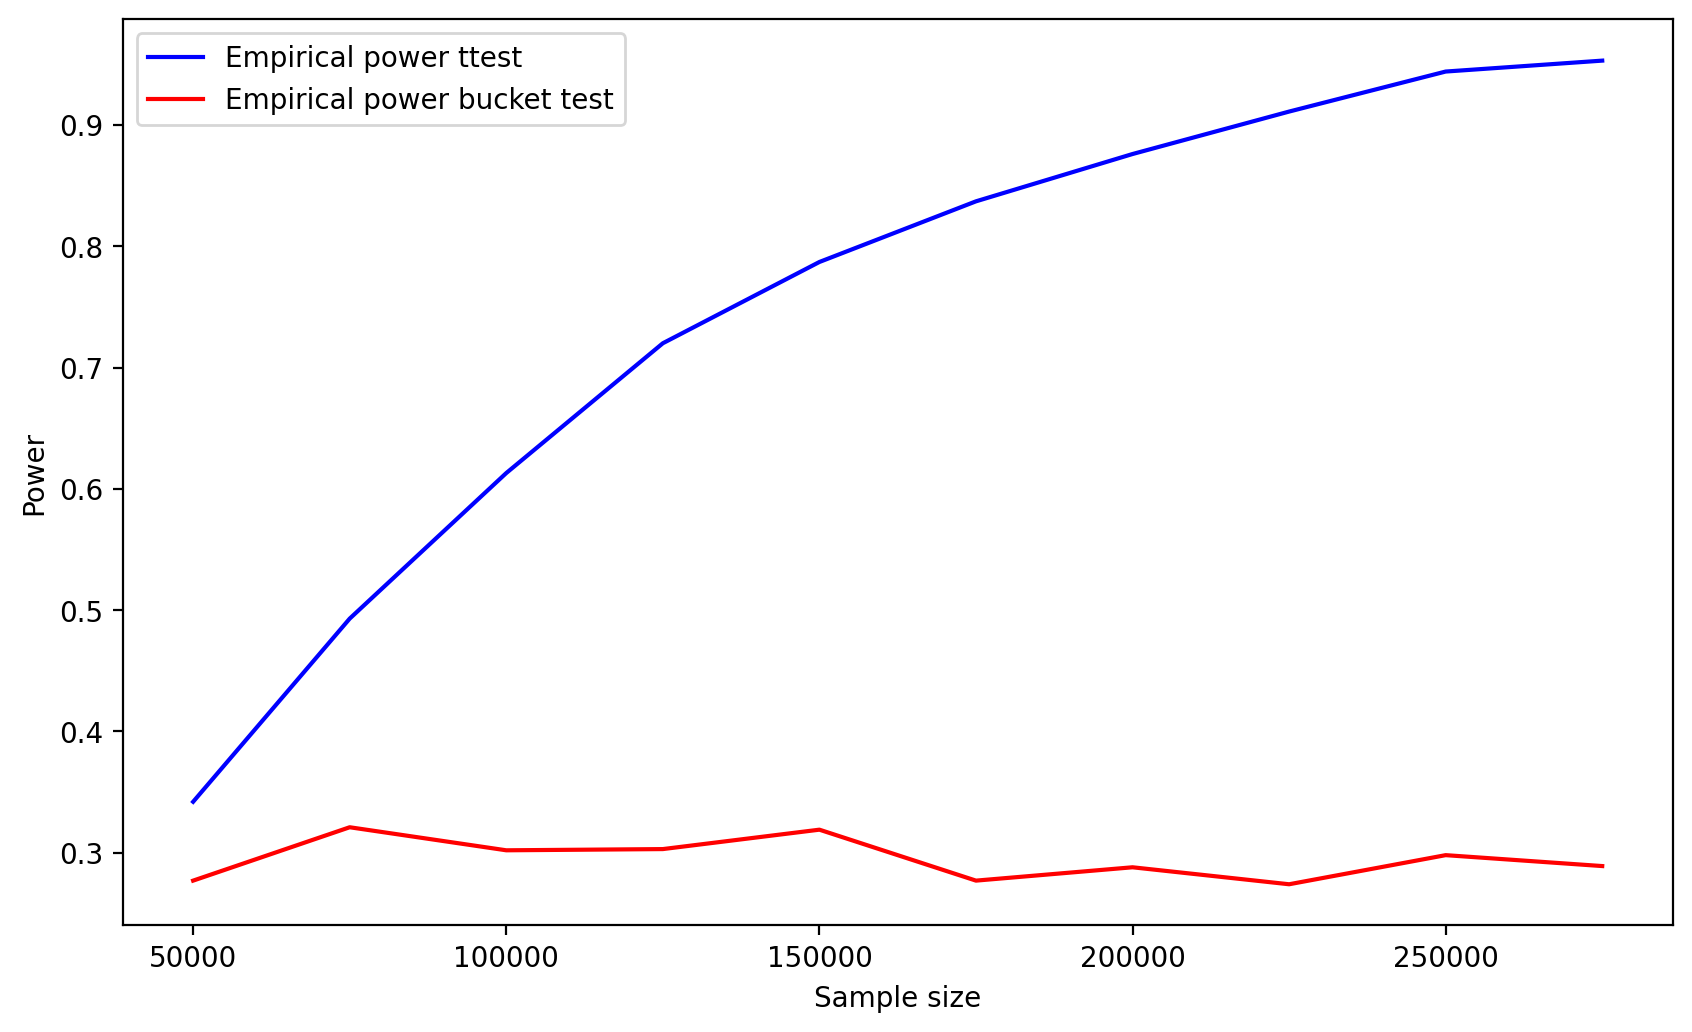

In [66]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)
ax.plot(sample_size, power_ttest, '-', 
        label='Empirical power ttest', color='blue')
ax.plot(sample_size, power_bucket, '-', 
        label='Empirical power bucket test', color='red')
plt.xlabel('Sample size')
plt.ylabel('Power')
ax.legend(loc='upper left');

In [74]:
# Зададим исходные параметры
sig = 0.025 # уровень значимости
p_a = 0.5 # мат.ожидание генеральной совокупности А
p_b = p_a*1.01 # мат.ожидание генеральной совокупности B
z_sig = sps.norm.ppf(1-sig) # 97.5 процентиль стандартного нормального распределения
N = 1000
buckets_num = 200

power_bucket = []
power_ztest = []
sample_size = []

for n in tqdm_notebook(range(50000, 300000, 25000)):
    
    results_ztest = []
    results_bucket = []
    
    for i in tqdm_notebook(range(N)):

        sample_a = sps.bernoulli.rvs(p_a, size=n)
        sample_b = sps.bernoulli.rvs(p_b, size=n)
        res_ztest = proportion_ztest(sample_a, sample_b, z_sig)
        results_ztest.append(res_ztest)  
        
        bucketized_sample_a = []
        bucketized_sample_b = []
        for b in range(buckets_num):
            bucket_a = sample_a[:buckets_num]
            bucketized_sample_a.append(np.mean(bucket_a))
            sample_a = sample_a[buckets_num:]
            
            bucket_b = sample_b[:buckets_num]
            bucketized_sample_b.append(np.mean(bucket_b))
            sample_b = sample_b[buckets_num:]
        res_bucket = ttest(bucketized_sample_a, bucketized_sample_b, z_sig)
        results_bucket.append(res_bucket)
           
    power_ztest.append(np.mean(results_ztest))
    power_bucket.append(np.mean(results_bucket))
    sample_size.append(n)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

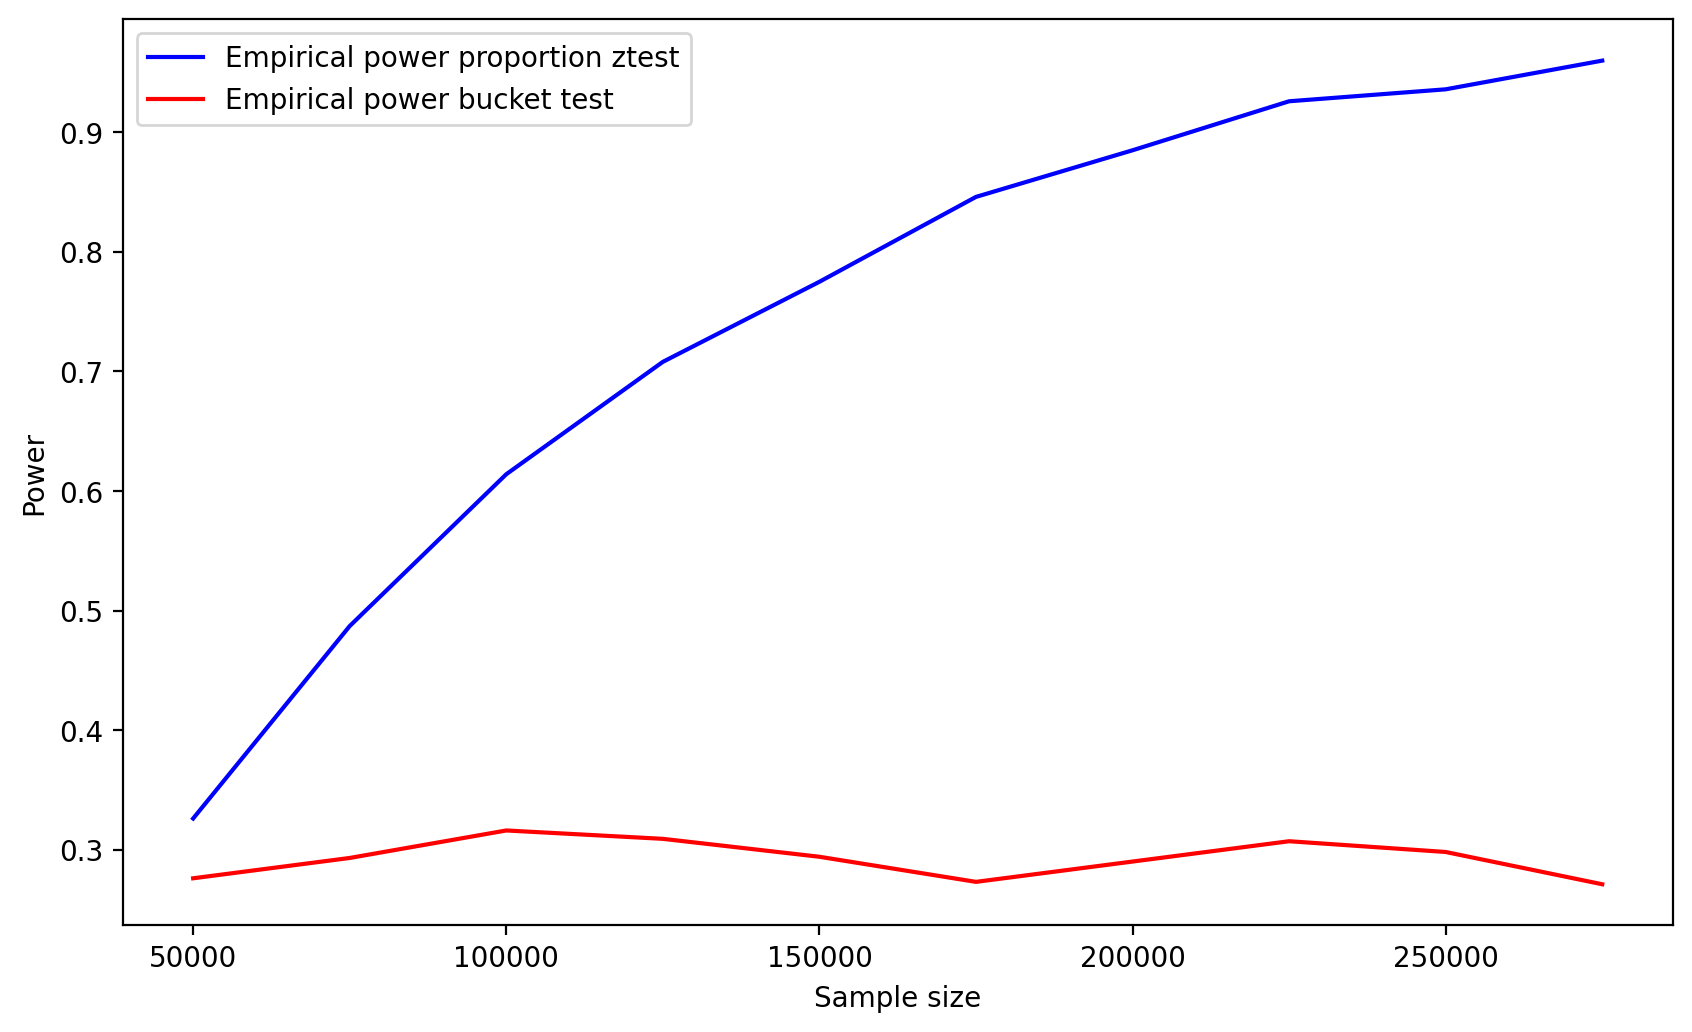

In [75]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)
ax.plot(sample_size, power_ztest, '-', 
        label='Empirical power proportion ztest', color='blue')
ax.plot(sample_size, power_bucket, '-', 
        label='Empirical power bucket test', color='red')
plt.xlabel('Sample size')
plt.ylabel('Power')
ax.legend(loc='upper left');